<a href="https://colab.research.google.com/github/MaxTheMooshroom/DS-Unit-2-Linear-Models/blob/master/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [X] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [X] Fit a ridge regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [63]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [64]:
print(df.shape)
# Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]
subset.shape

(23040, 21)


(3151, 21)

In [65]:
print(max(subset['SALE_PRICE']))
print(min(subset['SALE_PRICE']))

1955000
104000


In [66]:
subset['SALE_DATE'].tail(1)

23035    04/30/2019
Name: SALE_DATE, dtype: object

In [67]:
subset['SALE_DATE'] = pd.to_datetime(subset['SALE_DATE'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
subset['SALE_DATE'].tail()

23029   2019-04-30
23031   2019-04-30
23032   2019-04-30
23033   2019-04-30
23035   2019-04-30
Name: SALE_DATE, dtype: datetime64[ns]

In [69]:
# Do train/test split. Use data from January — March 2019 to train.
train = subset[(subset['SALE_DATE'].dt.month < 4) & (subset['SALE_DATE'].dt.year == 2019)]
print(train['SALE_DATE'].dt.month.unique())
print(train['SALE_DATE'].dt.year.unique())

[1 2 3]
[2019]


In [70]:
# Do train/test split. Use data from April 2019 to test.
test = subset[(subset['SALE_DATE'].dt.month == 4) & (subset['SALE_DATE'].dt.year == 2019)]
print(test['SALE_DATE'].dt.month.unique())
print(test['SALE_DATE'].dt.year.unique())

[4]
[2019]


In [0]:
# hot-encode
from sklearn.preprocessing import OneHotEncoder 
onehotencoder = OneHotEncoder(categorical_features = [0]) 

In [72]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,6,OTHER,2382,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
ADDRESS,2507,2497,118-20 202ND STREET,2,NaT,NaT


In [73]:
train.select_dtypes(exclude='number').columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS',
       'APARTMENT_NUMBER', 'LAND_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'],
      dtype='object')

In [74]:
train['EASE-MENT'].value_counts(dropna=False)

NaN    2507
Name: EASE-MENT, dtype: int64

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
                    'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER',
                    'LAND_SQUARE_FEET', 'BUILDING_CLASS_AT_TIME_OF_SALE', 
                    'SALE_DATE', 'EASE-MENT']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [76]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,3,OTHER,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,4,OTHER,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,2,OTHER,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,3,OTHER,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,3,OTHER,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1


In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

In [0]:
X_train = encoder.fit_transform(X_train)

In [0]:
X_test = encoder.transform(X_test)

In [0]:
# Do feature selection with SelectKBest.
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)

In [119]:
X_train_selected = pd.DataFrame(selector.fit_transform(X_train, y_train), columns=X_train.columns[selector.get_support()])
X_test_selected = pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])

print(X_train.shape, X_train_selected.shape)
print(X_test.shape, X_test_selected.shape)

(2507, 20) (2507, 10)
(644, 20) (644, 10)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [82]:
X_train_selected.head()

,BOROUGH_3,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FOREST HILLS,BLOCK,ZIP_CODE,TOTAL_UNITS,GROSS_SQUARE_FEET
0,1.0,0.0,0.0,1.0,0.0,0.0,5495.0,11230.0,1.0,1325.0
1,0.0,0.0,0.0,1.0,0.0,0.0,7918.0,11427.0,1.0,2001.0
2,0.0,1.0,0.0,1.0,0.0,0.0,4210.0,10461.0,1.0,2043.0
3,1.0,0.0,0.0,1.0,0.0,0.0,5212.0,11226.0,1.0,2680.0
4,1.0,0.0,0.0,1.0,0.0,0.0,7930.0,11203.0,1.0,1872.0


In [83]:
X_test_selected.head()

,BOROUGH_3,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FOREST HILLS,BLOCK,ZIP_CODE,TOTAL_UNITS,GROSS_SQUARE_FEET
0,0.0,1.0,0.0,1.0,0.0,0.0,5913.0,10471.0,1.0,2272.0
1,0.0,1.0,0.0,1.0,0.0,0.0,5488.0,10465.0,1.0,720.0
2,1.0,0.0,0.0,1.0,0.0,0.0,5936.0,11209.0,1.0,2210.0
3,1.0,0.0,0.0,1.0,0.0,0.0,7813.0,11210.0,1.0,1520.0
4,1.0,0.0,0.0,1.0,0.0,0.0,8831.0,11229.0,1.0,840.0


In [0]:
# Do feature scaling. Use the scaler's fit_transform method with the train set. Use the scaler's transform method with the test set.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(True, True)

In [85]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_selected, y_train), columns=X_train_selected.columns)
X_train_scaled

,BOROUGH_3,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FOREST HILLS,BLOCK,ZIP_CODE,TOTAL_UNITS,GROSS_SQUARE_FEET
0,2.301955,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,-0.317803,0.478764,-0.023223,-0.248281
1,-0.434413,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,0.291739,0.877393,-0.023223,0.880082
2,-0.434413,3.059331,-0.599005,0.229078,-0.178009,-0.082628,-0.641064,-1.077309,-0.023223,0.950187
3,2.301955,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,-0.388996,0.470670,-0.023223,2.013452
4,2.301955,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,0.294758,0.424129,-0.023223,0.664758
...,...,...,...,...,...,...,...,...,...,...
2502,-0.434413,-0.326869,1.669434,0.229078,-0.178009,-0.082628,-0.673516,-1.390952,-0.023223,-0.922628
2503,-0.434413,-0.326869,1.669434,0.229078,-0.178009,-0.082628,-1.103189,-1.374764,-0.023223,1.092067
2504,-0.434413,-0.326869,1.669434,0.229078,-0.178009,-0.082628,-1.415381,-1.399046,-0.023223,0.556262
2505,-0.434413,-0.326869,1.669434,0.229078,-0.178009,-0.082628,-0.846090,-1.392975,-0.023223,-1.423381


In [86]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test_selected), columns=X_test_selected.columns)
X_test_scaled

,BOROUGH_3,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FOREST HILLS,BLOCK,ZIP_CODE,TOTAL_UNITS,GROSS_SQUARE_FEET
0,-0.434413,3.059331,-0.599005,0.229078,-0.178009,-0.082628,-0.212649,-1.057074,-0.023223,1.332428
1,-0.434413,3.059331,-0.599005,0.229078,-0.178009,-0.082628,-0.319564,-1.069215,-0.023223,-1.258132
2,2.301955,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,-0.206863,0.436270,-0.023223,1.228939
3,2.301955,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,0.265325,0.438293,-0.023223,0.077208
4,2.301955,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,0.521418,0.476740,-0.023223,-1.057831
...,...,...,...,...,...,...,...,...,...,...
639,-0.434413,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,1.624279,0.867276,-0.023223,0.007103
640,-0.434413,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,1.221020,0.863229,-0.023223,-0.323394
641,-0.434413,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,1.270327,0.863229,-0.023223,-0.234928
642,-0.434413,-0.326869,-0.599005,0.229078,-0.178009,-0.082628,1.392839,0.891558,-0.023223,-0.757380


In [0]:
# Fit a ridge regression model with multiple features.
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [129]:
model = RidgeCV()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
#print(y_pred)

# Get mean absolute error for the test set.
mae = mean_absolute_error(y_test, y_pred)
print(f"{mae: .0f}")
coefficients = pd.DataFrame(model.coef_, X_train_selected.columns)
plt.figure(figsize=(16,8))
coefficients.sort_values().plot.barh(color='grey')
plt.show()

 162164


TypeError: ignored

In [112]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)
for k in range(1, len(X_train_selected.columns) + 1):
   print(f'{k} features')
   selector = SelectKBest(score_func=f_regression, k=k)
   X_train_selected = selector.fit_transform(X_train_scaled, y_train)
   X_test_selected = selector.transform(X_test_scaled)
   model = RidgeCV()
   model.fit(X_train_selected, y_train)
   y_pred = model.predict(X_test_selected)
   mae = mean_absolute_error(y_test, y_pred)
   print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,670 

2 features
Test MAE: $174,540 

3 features
Test MAE: $175,174 

4 features
Test MAE: $173,644 

5 features
Test MAE: $174,194 

6 features
Test MAE: $173,974 

7 features
Test MAE: $169,642 

8 features
Test MAE: $170,429 

9 features
Test MAE: $169,787 

10 features
Test MAE: $162,164 



In [0]:
%matplotlib inline

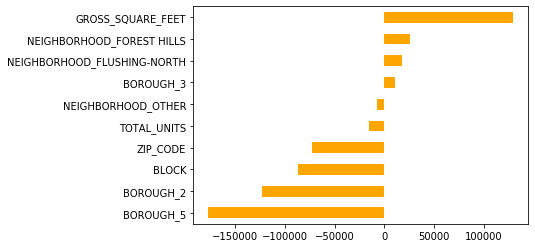

In [147]:
coefficients = pd.Series(model.coef_, X_train_selected.columns)
coefficients.sort_values().plot.barh(color='orange');

In [144]:
print(coefficients.to_string())

BOROUGH_3                       10454.682841
BOROUGH_2                     -123261.818692
BOROUGH_5                     -176977.503703
NEIGHBORHOOD_OTHER              -7635.012077
NEIGHBORHOOD_FLUSHING-NORTH     18278.673129
NEIGHBORHOOD_FOREST HILLS       26078.632244
BLOCK                          -86537.005355
ZIP_CODE                       -72364.356155
TOTAL_UNITS                    -15493.697713
GROSS_SQUARE_FEET              129040.169783
